
Import the necessary modules

In [181]:
import matplotlib.pyplot as plt
import random as rd
import numpy as np
import contextlib
import itertools
import utils
import time
import sys
import io

from tqdm import tqdm
from heapq import heappop, heappush
from utils import pretty_print_timetable
from check_constraints import check_mandatory_constraints

In [ ]:
class Day:
    def __init__(self, name):
        self.name = name

In [ ]:
class Interval:
    def __init__(self, interval):
        self.interval = interval

In [ ]:
class Subject:
    def __init__(self, name, capacity):
        self.name = name
        self.capacity = capacity
        self.occupied = 0
    
    def is_covered(self):
        return self.occupied >= self.capacity

    def update(self, lecture_hall):
        self.occupied += lecture_hall.capacity

    def restart(self):
        self.occupied = 0

In [ ]:
class Constraints:
    def __init__(self, constraints):
        days = ["Luni", "Marti", "Miercuri", "Joi", "Vineri", "Sambata", "Duminica"]
        self.prefferable_days = []
        self.prefferable_intervals = []
        self.c_pauses = []
        
        for c in constraints:
            if c in days:
                self.prefferable_days.append(c)
            
            if "-" in c and not "!" in c:
                self.prefferable_intervals.append(c)

            if "Pauza" in c:
                self.c_pauses.append(c)

In [ ]:
class Teacher:
    def __init__(self, name, constraints, subjects):
        self.name = name
        self.num_intervals = 0
        self.constraints = Constraints(constraints)
        self.subjects = subjects

    def is_available(self):
        return self.num_intervals < 7

    def is_specialized(self, s):
        """
            Tells if the teacher may teach the subject s received as a parameter
        """
        return s in self.subjects

    def update(self):
        self.num_intervals += 1

    def restart(self):
        self.num_intervals = 0
        
    def matches_requirements(self, searched_slot, slots):
        return not any(slot.teacher == self for slot in [s for s in slots if s.interval == searched_slot.interval and s.day == searched_slot.day])


In [ ]:
class LectureHall:
    def __init__(self, name, capacity, subjects):
        self.name = name
        self.capacity = capacity
        self.subjects = subjects

In [ ]:
class Slot:
    def __init__(self, day, interval, lecture_hall):
        self.day = day
        self.interval = interval
        self.lecture_hall = lecture_hall

        self.teacher = None
        self.subject = None

    def is_available(self):
        return (self.subject is None) or (self.teacher is None)

    def matches_requirements(self, lecture_hall, slots, teacher = None):
        return self.lecture_hall.name == lecture_hall.name and (teacher is None or\
            not any(slot.teacher == teacher for slot in [s for s in slots if s.interval == self.interval and s.day == self.day]))

    def update(self, subject, teacher):
        self.subject = subject
        self.teacher = teacher

    def restart(self):
        self.subject = None
        self.teacher = None

    def swap(self, other):
        self.subject, other.subject = other.subject, self.subject
        self.teacher, other.teacher = other.teacher, self.teacher

    def can_swap(self, other, timetable):
        def can_swap_helper(s1, s2, timetable):
            if s2.teacher is None or s2.lecture_hall is None:
                return True

            # Take all the slots from the same day and intervals
            same_interval_slots = [s for s in timetable["timetable"].slots\
                if s.day == s1.day and s.interval == s1.interval and s != s1]

            # Check if the s2 teacher has another class
            teacher_cond = not any(s2.teacher == s.teacher for s in same_interval_slots)

            # Check if the s2 lecture hall is used in that interval
            lecture_hall_cond = not any(s2.lecture_hall == s.lecture_hall for s in same_interval_slots)

            return teacher_cond and lecture_hall_cond
        
        return can_swap_helper(self, other, timetable) and can_swap_helper(other, self, timetable)


In [ ]:
class Timetable:
    def __init__(self, days, interval, lecture_halls):
        self.slots = []
        for d in days:
            for i in interval:
                for l in lecture_halls:
                    self.slots.append(Slot(d, i, l))

In [ ]:
def process_data(data):
    # Initialize Days and Intervals
    days = [Day(day_name) for day_name in data["Zile"]]
    intervals = [Interval(interval) for interval in data["Intervale"]]

    # Initialize subjects
    subjects = [Subject(name, capacity) for name, capacity in data["Materii"].items()]
    
    # Initialize lecture halls
    lecture_halls = [LectureHall(name, details["Capacitate"], [s for s in subjects if s.name in details["Materii"]]) for name, details in data["Sali"].items()]

    # Create empty timetable
    timetable = Timetable(days, intervals, lecture_halls)

    # Initialize teachers
    teachers = [Teacher(name, details["Constrangeri"], [s for s in subjects if s.name in details["Materii"]]) for name, details in data["Profesori"].items()]
    
    return {
        "timetable": timetable,
        "days": days,
        "intervals": intervals,
        "subjects": subjects,
        "lecture_halls": lecture_halls,
        "teachers": teachers
    }

In [ ]:
def print_data(data):
    print("Timetable Slots:")
    for slot in data["timetable"].slots:
        slot_details = f"{slot.day.name} {slot.interval.interval}, Subject: {slot.subject.name if slot.subject else 'None'}, "
        slot_details += f"Teacher: {slot.teacher.name if slot.teacher else 'None'}, "
        slot_details += f"Hall: {slot.lecture_hall.name if slot.lecture_hall else 'None'}"
        print(slot_details)

    print("\nSubjects:")
    for subject in data["subjects"]:
        print(f"{subject.name}, Capacity: {subject.capacity}, Occupied: {subject.occupied}")

    print("\nLecture Halls:")
    for hall in data["lecture_halls"]:
        subjects = ', '.join([s.name for s in hall.subjects])
        print(f"{hall.name}, Capacity: {hall.capacity}, Subjects: {subjects}")

    print("\nTeachers:")
    for teacher in data["teachers"]:
        subjects = ', '.join([s.name for s in teacher.subjects])
        constraints = f"Days: {', '.join(teacher.constraints.prefferable_days)}, Intervals: {', '.join(teacher.constraints.prefferable_intervals)}, Pauses: {', '.join(teacher.constraints.c_pauses)}"
        print(f"{teacher.name}, Subjects: {subjects}, Constraints: {constraints}")

In [ ]:
def get_interval_tuple(interval, delimiter=", "):
    if delimiter == "-":
        splitted = interval.split(delimiter)
    else:
        splitted = interval[1:len(interval) - 1].split(delimiter)
    
    first = int(splitted[0])
    second = int(splitted[1])
    return (first, second)

In [ ]:
def save_timetable(data, file_path):
    processed_data = {}

    for d in data["days"]:
        processed_data[d.name] = {}
        for i in data["intervals"]:
            processed_data[d.name][get_interval_tuple(i.interval)] = {}
            
    for slot in data["timetable"].slots:
        processed_data[slot.day.name][get_interval_tuple(slot.interval.interval)][slot.lecture_hall.name] = (slot.teacher.name, slot.subject.name) if slot.teacher else None
    
    pretty_data = pretty_print_timetable(processed_data, file_path)

    with open(f"outputs/{file_path.split('/')[1].split('.')[0]}.txt", "w") as f:
        f.writelines(pretty_data)
    

Function to run the algorithm


In [ ]:
def run_algorithm(file_path, func, h=None) -> None:
    data = process_data(utils.read_yaml_file(file_path))

    if h is not None:
        data["h"] = h

    # TODO run the algorithm
    func(data, file_path)

In [ ]:
def is_solution(timetable, specs):
    return not check_mandatory_constraints(timetable.state, specs)

In [ ]:
def astar(data):
    h = data["h"]
    
    # Initialize empty timetable
    start_timetable = Timetable(0, h(data), h, data)
    
    OPEN = []
    CLOSED = set()
    heappush(OPEN, (start_timetable.f, start_timetable))
    
    while OPEN:
        _, curr = heappop(OPEN)

        if is_solution(curr, data):
            return curr

        CLOSED.add(curr)
        for SUCC in curr.generate_successors():
            if SUCC not in CLOSED:
                heappush(OPEN, (SUCC.f, SUCC))
    
    
    

In [ ]:
def h1():
    pass

In [174]:
class RandomRestartHillClimbing():
    no_swaps = 0

    def __all_subjects_covered(subjects):
        return all(s.is_covered() for s in subjects)
    
    def __interval_constraint_breach(interval, searched_intervals):
        return not any(interval[0] >= i[0] and interval[1] <= i[1] for i in searched_intervals)
    
    def __filter_slots_by_teacher(slots, teacher):
        filtered_slots = []
        prefferable_intervals = [get_interval_tuple(interval, "-") for interval in teacher.constraints.prefferable_intervals]

        # Try to filter the slots that matches teacher's prefferences for days and intervals
        for slot in slots:
            slot_interval = get_interval_tuple(slot.interval.interval)
            if slot.day.name in teacher.constraints.prefferable_days and not RandomRestartHillClimbing.__interval_constraint_breach(slot_interval, prefferable_intervals):
                filtered_slots.append(slot)

        if filtered_slots:
            return filtered_slots

        # Try to filter the slots for at least one of the teacher's prefferences
        for slot in slots:
            slot_interval = get_interval_tuple(slot.interval.interval)
            if slot.day.name in teacher.constraints.prefferable_days or not RandomRestartHillClimbing.__interval_constraint_breach(slot_interval, prefferable_intervals):
                filtered_slots.append(slot)
        
        if filtered_slots:
            return filtered_slots
        else:
            # If there were'nt found any filtered slots, then return the slots and consider
            # the teacher's prefferences when swapping
            return slots

    def __filter_teachers_by_slot(teachers, slot):
        filtered_teachers = []
        slot_interval = get_interval_tuple(slot.interval.interval)

        # Try to filter the teachers that matches slot's day and interval
        for teacher in teachers:
            prefferable_intervals = [get_interval_tuple(interval, "-") for interval in teacher.constraints.prefferable_intervals]
            if slot.day.name in teacher.constraints.prefferable_days and not RandomRestartHillClimbing.__interval_constraint_breach(slot_interval, prefferable_intervals):
                filtered_teachers.append(teacher)
        
        if filtered_teachers:
            return filtered_teachers

        # Try to filter the teachers for with less constraints violated
        for teacher in teachers:
            prefferable_intervals = [get_interval_tuple(interval, "-") for interval in teacher.constraints.prefferable_intervals]
            if slot.day.name in teacher.constraints.prefferable_days or not RandomRestartHillClimbing.__interval_constraint_breach(slot_interval, prefferable_intervals):
                filtered_teachers.append(teacher)
        
        if filtered_teachers:
            return filtered_teachers
        else:
            # If there were'nt found any filtered teachers, then return the teachers and consider
            # the teacher's prefferences when swapping
            return teachers

    def restart_random_restart_hill_climbing():
        RandomRestartHillClimbing.no_swaps = 0
    
    def generate_initial_state_restart(data, restarts):
        for slot in data["timetable"].slots:
            slot.restart()

        for s in data["subjects"]:
            s.restart()
    
        for t in data["teachers"]:
            t.restart()

        restarts += 1

        sys.stdout.write(f"\rRestarts: {restarts}")
        sys.stdout.flush()

        return data, restarts
    
    def generate_initial_state(data):
        restarts = 0
        print("\nStarting to generate the initial state...")
        slots = data["timetable"].slots

        while not RandomRestartHillClimbing.__all_subjects_covered(data["subjects"]):
            # Choose a random subject
            s = rd.choice([s for s in data["subjects"] if not s.is_covered()])

            while not s.is_covered():
                # Choose a random lecture hall
                try:
                    l = rd.choice([l for l in data["lecture_halls"] if s in l.subjects])
                except IndexError:
                    # if there is an IndexError, it means that the choice() method was applied on an empty list
                    # therefore there are no lecture halls available so the generating algorithm has to be restarted
                    data, restarts = RandomRestartHillClimbing.generate_initial_state_restart(data, restarts)
                    break

                # Choose a random slot
                try:
                    slot = rd.choice([slot for slot in slots\
                        if slot.is_available() and slot.matches_requirements(l, slots)])
                except IndexError:
                    # if there is an IndexError, it means that the choice() method was applied on an empty list
                    # therefore there are no slots available so the generating algorithm has to be restarted
                    data, restarts = RandomRestartHillClimbing.generate_initial_state_restart(data, restarts)
                    break
                
                # Choose a random teacher
                try:
                    t = rd.choice(RandomRestartHillClimbing.__filter_teachers_by_slot([t for t in data["teachers"]\
                        if t.is_available() and t.is_specialized(s) and t.matches_requirements(slot, slots)], slot))
                except IndexError:
                    # if there is an IndexError, it means that the choice() method was applied on an empty list
                    # therefore there are no teachers available so the generating algorithm has to be restarted
                    data, restarts = RandomRestartHillClimbing.generate_initial_state_restart(data, restarts)
                    break
            
                slot.update(s, t)
                s.update(l)
                t.update()
        sys.stdout.write(f"\rRestarts: {restarts}")
        sys.stdout.flush()
        print("\nGenerating the initial state - DONE")
        return data
    
    def eval(timetable):
        """
            This is the method used for evaluating the cost of the current state/timetable.
            It is used in Hill Climbing algorithm for choosing the next state.
            The cost consists in the number of constraints that are not breached.

            Used primarily for:
                if Eval(S') > Eval(S) return S, where S' is max(s for s in SUCC(S))
        """
        cost = 0
        slots = timetable["timetable"].slots
    
        # Evaluate each slot in the timetable
        for slot in slots:
            # If the slot is not available, it means there are a teacher and a subject allocated for the slot
            if not slot.is_available():
                # Day constraint breach
                if slot.day.name not in slot.teacher.constraints.prefferable_days:
                    cost += 1
                
                # Interval constraint breach
                slot_interval = get_interval_tuple(slot.interval.interval)
                prefferable_intervals = [get_interval_tuple(interval, "-") for interval in slot.teacher.constraints.prefferable_intervals]
                if RandomRestartHillClimbing.__interval_constraint_breach(slot_interval, prefferable_intervals):
                    cost += 1

        return cost

    def generate_successor(S, improvement):
        """
            Generate all successors from the current timetable.
            These successors are similar to the latter timetable,
            as there is just a swap taking place, interchanging two slots
            for example.
            This approach is useful for reducing the number of constraints.
            Choose the best one based on the eval() method.
        """
        best_swap = None
        best_cost = RandomRestartHillClimbing.eval(S)
        slot_swaps = list(itertools.combinations(S["timetable"].slots, 2))

        # Keep the same variable/timetable to avoid deep copy and duplicating overhead
        for s1, s2 in slot_swaps:
            # Check if the swap will cause breaches among the hard constraints
            if not s1.can_swap(s2, S):
                continue

            # Realize the swap
            s1.swap(s2)

            # If the new state's cost is better than the best cost, update the best swap
            new_cost = RandomRestartHillClimbing.eval(S)
            if new_cost < best_cost or (improvement and new_cost == best_cost):
                best_swap = (s1, s2)
                best_cost = new_cost

            # Undo the swap to proceed with the next ones
            s1.swap(s2)
            RandomRestartHillClimbing.no_swaps += 1

        if best_swap:
            s1, s2 = best_swap[0], best_swap[1]
            s1.swap(s2)
            return S, False, best_cost
        else:
            # No better state found, should stop
            return S, True, best_cost

In [191]:
def random_restart_hill_climbing(file_path, improvement=False, improvement_limit=500):
    """
        improvement parameter is used for continuing the search over Eval(S') = Eval(S)
    """
    progress = tqdm(range(100), desc="Random Restarts")
    iteration = 0
    best_cost = -1
    initial_improvement_limit = improvement_limit
    # As in the course slides - aprox. 100 lateral moves for improvement
    for i in progress:
        iteration = i

        # Generate the initial state (always read and process data to avoid keeping unnecessary data in memory)
        S = RandomRestartHillClimbing.generate_initial_state(process_data(utils.read_yaml_file(file_path)))

        # Generate the best successor. If the best one is no better than the current state, it should stop.
        stop = False
        prev_best_cost = -1
        while not stop:
            S, stop, best_cost = RandomRestartHillClimbing.generate_successor(S, improvement)

            if improvement and prev_best_cost == best_cost:
                improvement_limit -= 1
                if improvement_limit <= 0:
                    break
            if prev_best_cost != best_cost:
                improvement_limit = initial_improvement_limit
            prev_best_cost = best_cost

        print("Best cost found!", best_cost)
            
        if best_cost == 0:
            progress.update(100 - progress.n) 
            break

    save_timetable(S, file_path)
    RandomRestartHillClimbing.restart_random_restart_hill_climbing()
    return iteration, best_cost
    

Run the algorithm for "dummy.yaml"

In [194]:
random_restart_hill_climbing("inputs/dummy.yaml", improvement=True, improvement_limit=50)

Random Restarts:   0%|          | 0/100 [00:00<?, ?it/s]


Starting to generate the initial state...
Restarts: 0

Random Restarts:   1%|          | 1/100 [00:00<00:17,  5.69it/s]


Generating the initial state - DONE
Best cost found! 1

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE


Random Restarts:   2%|▏         | 2/100 [00:00<00:18,  5.20it/s]

Best cost found! 1

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE


Random Restarts:   3%|▎         | 3/100 [00:00<00:19,  4.93it/s]

Best cost found! 1

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE


Random Restarts:   4%|▍         | 4/100 [00:00<00:18,  5.06it/s]

Best cost found! 2

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE


Random Restarts:   5%|▌         | 5/100 [00:01<00:20,  4.61it/s]

Best cost found! 1

Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE


Random Restarts: 100%|██████████| 100/100 [00:01<00:00, 144.87it/s]

Best cost found! 0


Random Restarts:   5%|▌         | 5/100 [00:01<00:24,  3.89it/s]   


(5, 0)

Run the algorithm for "orar_mic_exact.yaml"

In [197]:
random_restart_hill_climbing("inputs/orar_mic_exact.yaml", improvement=True, improvement_limit=20)

Random Restarts:   0%|          | 0/100 [00:00<?, ?it/s]


Starting to generate the initial state...
Restarts: 0
Generating the initial state - DONE


Random Restarts:   0%|          | 0/100 [00:01<?, ?it/s]          

Best cost found! 0


(0, 0)

Run the algorithm for "orar_mediu_relaxat.yaml"

In [ ]:
random_restart_hill_climbing("inputs/orar_mediu_relaxat.yaml")

Run the algorithm for "orar_constrans_incalcat.yaml"

In [ ]:
random_restart_hill_climbing("inputs/orar_constrans_incalcat.yaml")

Run the algorithm for "orar_mare_relaxat.yaml"

In [ ]:
random_restart_hill_climbing("inputs/orar_mare_relaxat.yaml")

Run the algorithm for all files

In [218]:
def collect_data(file_path, runs=5, improvement=False):
    results = np.zeros((runs, 2), dtype=int) # Array to store (iterations, best_cost)
    averages = {}

    for i in range(runs):
        iterations, best_cost = random_restart_hill_climbing(file_path, improvement, improvement_limit=4)
        if iterations not in averages:
            averages[iterations] = [best_cost]
        else:
            averages[iterations].append(best_cost)
        
    averages = {k: int(np.mean(v)) for k, v in averages.items()}
    return averages

def plot_random_restart_hc(file_path):
    results_without_improvement = collect_data(file_path, improvement=False)
    results_with_improvement = collect_data(file_path, improvement=True)

    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    print(results_without_improvement)
    print(results_with_improvement)
    # Plot without improvement
    axs[0].bar(results_without_improvement.values(), results_without_improvement.keys(), color='b', label='Iterations')
    axs[0].set_title(f'{file_path} - Random Restart HC Without Improvement')
    axs[0].set_xlabel('Best Cost')
    axs[0].set_ylabel('Iterations')
    axs[0].legend()

    # Plot with improvement
    axs[1].bar(results_with_improvement.values(), results_with_improvement.keys(), color='g', label='Iterations')
    axs[1].set_title(f'{file_path} - Random Restart HC With Improvement')
    axs[1].set_xlabel('Best Cost')
    axs[1].set_ylabel('Iterations')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

Random Restarts:   0%|          | 0/100 [00:00<?, ?it/s]


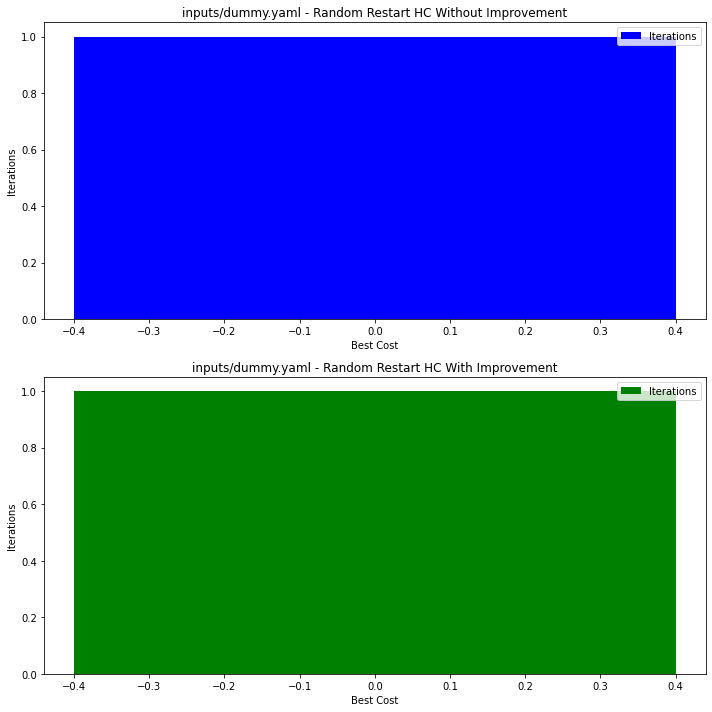

Random Restarts:   5%|▌         | 5/100 [00:05<01:45,  1.11s/it]  


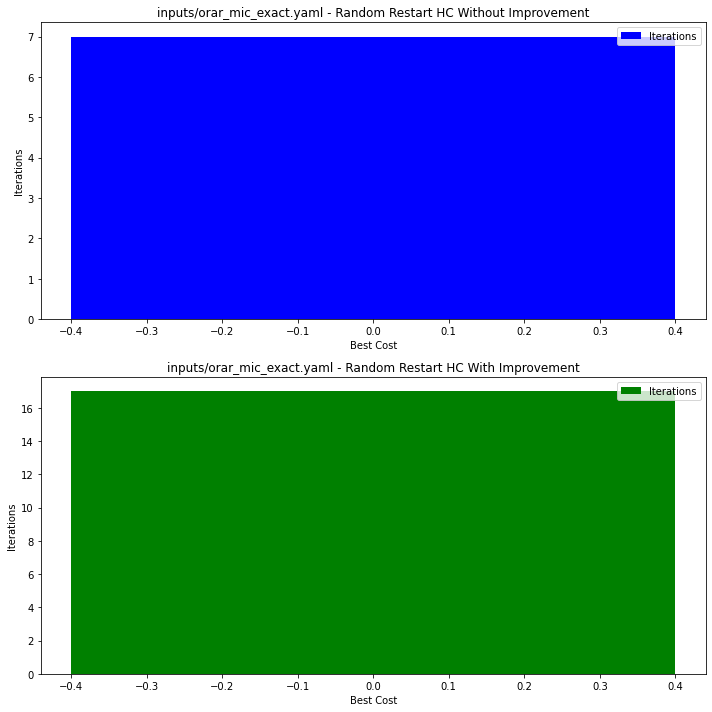

In [220]:
input_files = [
    "inputs/dummy.yaml",
    # "inputs/orar_bonus_exact.yaml",
    # "inputs/orar_constrans_incalcat.yaml",
    # "inputs/orar_mare_relaxat.yaml",
    # "inputs/orar_mediu_relaxat.yaml",
    "inputs/orar_mic_exact.yaml",
]

with contextlib.redirect_stdout(io.StringIO()):
    for input_file in input_files:
        plot_random_restart_hc(input_file)

# for file in input_files:
#     random_restart_hill_climbing(file)